In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np


import matplotlib.pyplot as plt
from scipy.integrate import odeint
import itertools
import sympy as sp

import gamelab.finitegames as nfg
import symplecticFTRL
import choice
import aspera.utils

In [3]:
primal_letter = 'x'
dual_letter = 'y'
quot_letter = 'z'

## Utils

In [4]:
# switch between coords and points
#def coords_points(L):

	#https://stackoverflow.com/questions/2921847/what-does-the-star-operator-mean-in-a-function-call
#	def make(*values):
#		return values

#	return make(*zip(*L))

In [5]:
flatten = nfg.Utils.flatten
coords_points = aspera.utils.coords_points

# Symplectic FTRL on mixed extension of $[2 \times 2 \times 2]$ normal form games

In [6]:
skeleton = [2, 2, 2]

In [7]:
BARE = nfg.NFG_bare(skeleton, "numeric", primal_letter)

In [8]:
help(nfg.NFG)

Help on class NFG in module gamelab.finitegames:

class NFG(NFG_bare)
 |  NFG(skeleton, strat_format, primal_letter, dual_letter, name, payoff_tensors)
 |
 |  docstring for ClassName
 |
 |  Method resolution order:
 |      NFG
 |      NFG_bare
 |      Skeleton
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, skeleton, strat_format, primal_letter, dual_letter, name, payoff_tensors)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  make_clean_payfield(self)
 |
 |  ----------------------------------------------------------------------
 |  Methods inherited from NFG_bare:
 |
 |  make_packed(self, letter, skeleton)
 |      Returns packed list of multi-indexed letter, e.g. [[x0_0, x0_1], [x1_0, x1_1]]
 |
 |  make_strat(self, xi, skeleton)
 |      - Given names for strats_play, say [x_0, x_1, x_2] or [x, y, z], generates corresponding strat
 |      - Initialize an empty list to store the symbolic entries
 |      - Returns list of sympy mat

In [9]:
BARE.strat

[Matrix([
 [x0_0],
 [x0_1]]),
 Matrix([
 [x1_0],
 [x1_1]]),
 Matrix([
 [x2_0],
 [x2_1]])]

In [10]:
BARE.primal_vars

[x0_0, x0_1, x1_0, x1_1, x2_0, x2_1]

In [11]:
BARE.make_vars('y', skeleton)

[y0_0, y0_1, y1_0, y1_1, y2_0, y2_1]

In [12]:
BARE.strat_play

(x0, x1, x2)

## Games

In [13]:
#  harmonic, for RL project met at Neurips (Baraah)
payoff = [7, -29, 1, 24, 2, -6, 7, 0, -15, 23, -10, 0, -3, -9, 2, 4, -8, -8, 1, 0, 4, -6, -6, 5]
GH = nfg.NFG(skeleton = skeleton , strat_format = 'numeric', primal_letter = primal_letter, dual_letter = dual_letter, name = 'Generalized Harmonic', payoff_tensors =  nfg.Utils.u_flat_to_tensor(payoff, skeleton))

In [14]:
GH.payoff_tensors

A = [0,1]
for a in A:
    for b in A:
        for c in A:
            print( f'{(a,b,c)} : { GH.payoff_tensors[0][a,b,c], GH.payoff_tensors[1][a,b,c], GH.payoff_tensors[2][a,b,c]  } ' )

(0, 0, 0) : (7, -15, -8) 
(0, 0, 1) : (-29, 23, -8) 
(0, 1, 0) : (1, -10, 1) 
(0, 1, 1) : (24, 0, 0) 
(1, 0, 0) : (2, -3, 4) 
(1, 0, 1) : (-6, -9, -6) 
(1, 1, 0) : (7, 2, -6) 
(1, 1, 1) : (0, 4, 5) 


In [15]:
GH.payfield

[[7*x1_0*x2_0 - 29*x1_0*x2_1 + x1_1*x2_0 + 24*x1_1*x2_1,
  2*x1_0*x2_0 - 6*x1_0*x2_1 + 7*x1_1*x2_0],
 [-15*x0_0*x2_0 + 23*x0_0*x2_1 - 3*x0_1*x2_0 - 9*x0_1*x2_1,
  -10*x0_0*x2_0 + 2*x0_1*x2_0 + 4*x0_1*x2_1],
 [-8*x0_0*x1_0 + x0_0*x1_1 + 4*x0_1*x1_0 - 6*x0_1*x1_1,
  -8*x0_0*x1_0 - 6*x0_1*x1_0 + 5*x0_1*x1_1]]

In [16]:
GH.quotpayfield

[array([0, -5*x1_0*x2_0 + 23*x1_0*x2_1 + 6*x1_1*x2_0 - 24*x1_1*x2_1],
       dtype=object),
 array([0, 5*x0_0*x2_0 - 23*x0_0*x2_1 + 5*x0_1*x2_0 + 13*x0_1*x2_1],
       dtype=object),
 array([0, -x0_0*x1_1 - 10*x0_1*x1_0 + 11*x0_1*x1_1], dtype=object)]

In [17]:
GH.map_payfield.present()


V: X0 x X1 x X2(6) --> TY0 x TY1 x TY2(6) 
 (x0_0, x0_1, x1_0, x1_1, x2_0, x2_1) --> (y'0_0, y'0_1, y'1_0, y'1_1, y'2_0, y'2_1) = [7*x1_0*x2_0 - 29*x1_0*x2_1 + x1_1*x2_0 + 24*x1_1*x2_1, 2*x1_0*x2_0 - 6*x1_0*x2_1 + 7*x1_1*x2_0, -15*x0_0*x2_0 + 23*x0_0*x2_1 - 3*x0_1*x2_0 - 9*x0_1*x2_1, -10*x0_0*x2_0 + 2*x0_1*x2_0 + 4*x0_1*x2_1, -8*x0_0*x1_0 + x0_0*x1_1 + 4*x0_1*x1_0 - 6*x0_1*x1_1, -8*x0_0*x1_0 - 6*x0_1*x1_0 + 5*x0_1*x1_1]


In [18]:
GH.map_quotpayfield.present()


v: X0 x X1 x X2(6) --> TZ0 x TZ1 x TZ2(6) 
 (x0_0, x0_1, x1_0, x1_1, x2_0, x2_1) --> (z'0_0, z'0_1, z'1_0, z'1_1, z'2_0, z'2_1) = [0, -5*x1_0*x2_0 + 23*x1_0*x2_1 + 6*x1_1*x2_0 - 24*x1_1*x2_1, 0, 5*x0_0*x2_0 - 23*x0_0*x2_1 + 5*x0_1*x2_0 + 13*x0_1*x2_1, 0, -x0_0*x1_1 - 10*x0_1*x1_0 + 11*x0_1*x1_1]


In [19]:
GH.map_eff_quotpayfield.present()


v: X0 x X1 x X2(3) --> TZ0 x TZ1 x TZ2(3) 
 (x0_1, x1_1, x2_1) --> (z'0_1, z'1_1, z'2_1) = [-58*x1_1*x2_1 + 11*x1_1 + 28*x2_1 - 5, 36*x0_1*x2_1 - 28*x2_1 + 5, 22*x0_1*x1_1 - 10*x0_1 - x1_1]


In [20]:
GH.eff_payfield

[[-58*x1_1*x2_1 + 11*x1_1 + 28*x2_1 - 5],
 [36*x0_1*x2_1 - 28*x2_1 + 5],
 [22*x0_1*x1_1 - 10*x0_1 - x1_1]]

In [21]:
#GAMES = [MP, GH, PD, SS, BS, CH, CO, ACO, CY]
GAMES = [GH]

## Vars

In [22]:
primal_vars = BARE.primal_vars
primal_vars

[x0_0, x0_1, x1_0, x1_1, x2_0, x2_1]

In [23]:
dual_vars = BARE.make_vars(dual_letter, skeleton)
dual_vars

[y0_0, y0_1, y1_0, y1_1, y2_0, y2_1]

In [24]:
quot_vars = BARE.make_vars(quot_letter, skeleton)
quot_vars

[z0_0, z0_1, z1_0, z1_1, z2_0, z2_1]

In [25]:
BARE.make_vars_play(dual_letter, skeleton)

(y0, y1, y2)

In [26]:
BARE.make_packed(dual_letter, skeleton)

[(y0_0, y0_1), (y1_0, y1_1), (y2_0, y2_1)]

In [27]:
logit = choice.MultiLogit(primal_letter, dual_letter, skeleton)
logit.Q.ex

Matrix([
[exp(y0_0)/(exp(y0_0) + exp(y0_1))],
[exp(y0_1)/(exp(y0_0) + exp(y0_1))],
[exp(y1_0)/(exp(y1_0) + exp(y1_1))],
[exp(y1_1)/(exp(y1_0) + exp(y1_1))],
[exp(y2_0)/(exp(y2_0) + exp(y2_1))],
[exp(y2_1)/(exp(y2_0) + exp(y2_1))]])

# Z quotient

In [28]:
quotlogit = choice.QuotientMultiLogit(primal_letter, dual_letter, skeleton, quot_letter)
quotlogit.Q.ex

Matrix([
[        1/(exp(z0_1) + 1)],
[exp(z0_1)/(exp(z0_1) + 1)],
[        1/(exp(z1_1) + 1)],
[exp(z1_1)/(exp(z1_1) + 1)],
[        1/(exp(z2_1) + 1)],
[exp(z2_1)/(exp(z2_1) + 1)]])

In [29]:
quotlogit.eff_Q.ex

Matrix([
[exp(z0_1)/(exp(z0_1) + 1)],
[exp(z1_1)/(exp(z1_1) + 1)],
[exp(z2_1)/(exp(z2_1) + 1)]])

### Access primal and dual spaces either by primal space and dual space of MultiLogit instance, or domain and codomain of Map instance

In [30]:
logit.primal_space.present()

X0 x X1 x X2 6 (x0_0, x0_1, x1_0, x1_1, x2_0, x2_1)


In [31]:
logit.Q.codomain.present()

X0 x X1 x X2 6 (x0_0, x0_1, x1_0, x1_1, x2_0, x2_1)


In [32]:
logit.dual_space.present()

Y0 x Y1 x Y2 6 (y0_0, y0_1, y1_0, y1_1, y2_0, y2_1)


In [33]:
logit.Q.domain.present()

Y0 x Y1 x Y2 6 (y0_0, y0_1, y1_0, y1_1, y2_0, y2_1)


## Symplectic FTRL

In [133]:
SFTRL_GAMES = [ symplecticFTRL.SFTRL(game.map_payfield, logit.Q, primal_vars, dual_vars, game.name) for game in GAMES ]

In [134]:
SFTRL_GAMES[0].choice( 1, 2, 3, 4, 5, 6 )

[0.2689414213699951,
 0.7310585786300049,
 0.2689414213699951,
 0.7310585786300048,
 0.26894142136999516,
 0.7310585786300049]

In [36]:
SFTRL_GAMES[0].payfield(1, 2, 3, 4, 5, 6)

[179, 62, -75, 18, -44, -20]

In [135]:
SFTRL_GAMES[0].dVQ_VQ(1, 2, 3, 4, 5, 6)

[-44.50146576171666,
 12.825894286768321,
 -96.00588709228569,
 68.0808502539754,
 -8.871031248133706,
 8.329814202918763]

In [137]:
SFTRL_GAMES[0].sftrl_dyn_2([1, 2, 3, 4, 5, 6], 0, 0)

array([ 1.471959  , -1.471959  , -0.74131331,  0.74131331, -0.73064569,
        0.73064569])

## Z FTRL

In [38]:
ZSFTRL_GAMES = [ symplecticFTRL.ZSFTRL(game.map_quotpayfield, quotlogit.Q, primal_vars, quot_vars, game.name) for game in GAMES ]

In [39]:
test = ZSFTRL_GAMES[0]

In [40]:
test.map_VQ.present()


v(q_0 x q_1 x q_2): Z0 x Z1 x Z2(6) --> TZ0 x TZ1 x TZ2(6) 
 (z0_0, z0_1, z1_0, z1_1, z2_0, z2_1) --> (z'0_0, z'0_1, z'1_0, z'1_1, z'2_0, z'2_1) = [0, (6*exp(z1_1) + 23*exp(z2_1) - 24*exp(z1_1 + z2_1) - 5)/((exp(z1_1) + 1)*(exp(z2_1) + 1)), 0, (5*exp(z0_1) - 23*exp(z2_1) + 13*exp(z0_1 + z2_1) + 5)/((exp(z0_1) + 1)*(exp(z2_1) + 1)), 0, (-10*exp(z0_1) - exp(z1_1) + 11*exp(z0_1 + z1_1))/((exp(z0_1) + 1)*(exp(z1_1) + 1))]


In [41]:
test.sym_JQ

Matrix([
[0,                              -exp(z0_1)/(exp(z0_1) + 1)**2, 0,                                                          0, 0,                                                          0],
[0, exp(z0_1)/(exp(z0_1) + 1) - exp(2*z0_1)/(exp(z0_1) + 1)**2, 0,                                                          0, 0,                                                          0],
[0,                                                          0, 0,                              -exp(z1_1)/(exp(z1_1) + 1)**2, 0,                                                          0],
[0,                                                          0, 0, exp(z1_1)/(exp(z1_1) + 1) - exp(2*z1_1)/(exp(z1_1) + 1)**2, 0,                                                          0],
[0,                                                          0, 0,                                                          0, 0,                              -exp(z2_1)/(exp(z2_1) + 1)**2],
[0,                                 

In [42]:
ZSFTRL_GAMES[0].VQ(1, 2, 3, 4, 5, 6)

[0, -23.083048877999293, 0, 8.699524602542583, 0, 9.239022719769528]

## Effective Z SFTRL

In [43]:
GH.map_eff_quotpayfield.present()


v: X0 x X1 x X2(3) --> TZ0 x TZ1 x TZ2(3) 
 (x0_1, x1_1, x2_1) --> (z'0_1, z'1_1, z'2_1) = [-58*x1_1*x2_1 + 11*x1_1 + 28*x2_1 - 5, 36*x0_1*x2_1 - 28*x2_1 + 5, 22*x0_1*x1_1 - 10*x0_1 - x1_1]


In [44]:
quotlogit.eff_Q.present()


q_0 x q_1 x q_2: Z0 x Z1 x Z2(3) --> X0 x X1 x X2(3) 
 (z0_1, z1_1, z2_1) --> (x0_1, x1_1, x2_1) = [exp(z0_1)/(exp(z0_1) + 1), exp(z1_1)/(exp(z1_1) + 1), exp(z2_1)/(exp(z2_1) + 1)]


In [45]:
quotlogit.eff_Q.domain.vars

(z0_1, z1_1, z2_1)

In [46]:
quotlogit.eff_Q.codomain.vars

(x0_1, x1_1, x2_1)

# Next cell takes very long (~5 minutes) to run bc of heavy symbolic computation

In [47]:
eff_ZSFTRL_GAMES = [ symplecticFTRL.ZSFTRL(game.map_eff_quotpayfield, quotlogit.eff_Q, quotlogit.eff_Q.codomain.vars, quotlogit.eff_Q.domain.vars, game.name) for game in GAMES ]

Init geometric version
pull done...
diff done...
product done...
Inverse done, Symbolic computations over


In [48]:
test = eff_ZSFTRL_GAMES[0]

In [49]:
test

In [50]:
test.map_VQ.present()


v(q_0 x q_1 x q_2): Z0 x Z1 x Z2(3) --> TZ0 x TZ1 x TZ2(3) 
 (z0_1, z1_1, z2_1) --> (z'0_1, z'1_1, z'2_1) = [(6*exp(z1_1) + 23*exp(z2_1) - 24*exp(z1_1 + z2_1) - 5)/(exp(z1_1) + exp(z2_1) + exp(z1_1 + z2_1) + 1), (5*exp(z0_1) - 23*exp(z2_1) + 13*exp(z0_1 + z2_1) + 5)/(exp(z0_1) + exp(z2_1) + exp(z0_1 + z2_1) + 1), (-10*exp(z0_1) - exp(z1_1) + 11*exp(z0_1 + z1_1))/(exp(z0_1) + exp(z1_1) + exp(z0_1 + z1_1) + 1)]


In [51]:
test.sym_JQ

Matrix([
[exp(z0_1)/(exp(z0_1) + 1) - exp(2*z0_1)/(exp(z0_1) + 1)**2,                                                          0,                                                          0],
[                                                         0, exp(z1_1)/(exp(z1_1) + 1) - exp(2*z1_1)/(exp(z1_1) + 1)**2,                                                          0],
[                                                         0,                                                          0, exp(z2_1)/(exp(z2_1) + 1) - exp(2*z2_1)/(exp(z2_1) + 1)**2]])

In [52]:
test.sym_JQ.inv()

Matrix([
[(exp(3*z0_1) + 3*exp(2*z0_1) + 3*exp(z0_1) + 1)/(exp(2*z0_1) + exp(z0_1)),                                                                         0,                                                                         0],
[                                                                        0, (exp(3*z1_1) + 3*exp(2*z1_1) + 3*exp(z1_1) + 1)/(exp(2*z1_1) + exp(z1_1)),                                                                         0],
[                                                                        0,                                                                         0, (exp(3*z2_1) + 3*exp(2*z2_1) + 3*exp(z2_1) + 1)/(exp(2*z2_1) + exp(z2_1))]])

In [53]:
test.sym_symplectic_vfield

Matrix([
[ -((cosh(z1_1) + 1)*(10*exp(z0_1) + exp(z1_1) - 11*exp(z0_1 + z1_1))*((exp(z0_1) + exp(z0_1 + z1_1))*(10*exp(z0_1) + exp(z1_1) - 11*exp(z0_1 + z1_1))*(exp(z1_1) + exp(z2_1) + exp(z1_1 + z2_1) + 1)**2*cosh(z0_1/2)**2 - (10*exp(z0_1) - 11*exp(z0_1 + z1_1))*(exp(z0_1) + exp(z1_1) + exp(z0_1 + z1_1) + 1)*(exp(z1_1) + exp(z2_1) + exp(z1_1 + z2_1) + 1)**2*cosh(z0_1/2)**2 + (exp(z2_1) + exp(z1_1 + z2_1))*(exp(z0_1) + exp(z1_1) + exp(z0_1 + z1_1) + 1)**2*(6*exp(z1_1) + 23*exp(z2_1) - 24*exp(z1_1 + z2_1) - 5)*cosh(z2_1/2)**2 - (23*exp(z2_1) - 24*exp(z1_1 + z2_1))*(exp(z0_1) + exp(z1_1) + exp(z0_1 + z1_1) + 1)**2*(exp(z1_1) + exp(z2_1) + exp(z1_1 + z2_1) + 1)*cosh(z2_1/2)**2)*(exp(z0_1) + exp(z2_1) + exp(z0_1 + z2_1) + 1)**3 + (cosh(z2_1) + 1)*((exp(z0_1) + exp(z0_1 + z2_1))*(5*exp(z0_1) - 23*exp(z2_1) + 13*exp(z0_1 + z2_1) + 5)*(exp(z1_1) + exp(z2_1) + exp(z1_1 + z2_1) + 1)**2*cosh(z0_1/2)**2 - (5*exp(z0_1) + 13*exp(z0_1 + z2_1))*(exp(z0_1) + exp(z2_1) + exp(z0_1 + z2_1) + 1)*(exp(z1_

In [54]:
test.quot_vars

(z0_1, z1_1, z2_1)

In [55]:
eff_ZSFTRL_GAMES[0].symplectic_vfield(2,3, 4)

[37.61404933990687, 183.92741552455706, 79.63866103026568]

In [56]:
eff_ZSFTRL_GAMES[0].dVQ_VQ(2,3, 4)

[64.2117662248689, 129.824457139117, 28.114620963802675]

In [57]:
ZSFTRL_GAMES[0].dVQ_VQ(0, 2, 0, 3, 0, 4)

[0, 64.21176622486888, 0, 129.824457139117, 0, 28.114620963802693]

## ODE

# Experimenting: orbits with initial condition close to zeros of payfield

In [62]:
def invert_choice(x):
    
    # returns a possible (y1, y2) such that logit(y1, y2) = (1-x, x)

    a = np.log( (1-x) / x )
    
    return np.array([a, 0]) # up to additive constant
    

In [63]:
def make_initial_dual_point(x, y, z):
    # make possible initial dual point (flat, 6 numbers) correspnding to primal point [1-x, x, 1-y, y, 1-z, z]
    return flatten( [invert_choice(x), invert_choice(y), invert_choice(z)] )

In [64]:
make_initial_dual_point(0.5, 0.9, 0.2)

[0.0, 0.0, -2.1972245773362196, 0.0, 1.3862943611198906, 0.0]

In [65]:
invert_choice(0.5)

array([0., 0.])

In [66]:
invert_choice(0.9)

array([-2.19722458,  0.        ])

In [67]:
invert_choice(0.2)

array([1.38629436, 0.        ])

In [68]:
SFTRL_GAMES[0].choice(*invert_choice(0.5), *invert_choice(0.2), *invert_choice(0.9))

[0.5, 0.5, 0.8, 0.2, 0.09999999999999998, 0.8999999999999999]

# Critical points of payoff field

In [78]:
GH.eff_payfield

[[-58*x1_1*x2_1 + 11*x1_1 + 28*x2_1 - 5],
 [36*x0_1*x2_1 - 28*x2_1 + 5],
 [22*x0_1*x1_1 - 10*x0_1 - x1_1]]

In [79]:
system = [v[0] for v in GH.eff_payfield]
system
sol = sp.solve(system)
[print(s) for s in sol]

{x0_1: (28*x2_1 - 5)/(36*x2_1), x1_1: (28*x2_1 - 5)/(58*x2_1 - 11)}


[None]

In [80]:
system = [v[0] for v in GH.eff_payfield]
system
sol = sp.solve(system)
[print(s) for s in sol]

{x0_1: (28*x2_1 - 5)/(36*x2_1), x1_1: (28*x2_1 - 5)/(58*x2_1 - 11)}


[None]

In [81]:
def x_crit(z):
    return (28*z - 5)/(36*z)

def y_crit(z):
    return (28*z - 5)/(58*z - 11)

In [82]:
def hook(ax):
    # Define the range of y values
    x2_1_crit = np.linspace(0.2, 1, 1000)  # Adjust range and resolution as needed

    # Define x and z based on the solution, zeros of eff payfield
    x0_1_crit = (28*x2_1_crit - 5)/(36*x2_1_crit)
    x1_1_crit = (28*x2_1_crit - 5)/(58*x2_1_crit - 11)
    ax.plot(x0_1_crit, x1_1_crit, x2_1_crit, color = 'r', label = "critical points of payoff field V")
    #ax.legend(loc = 'best')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_zlim(0,1)

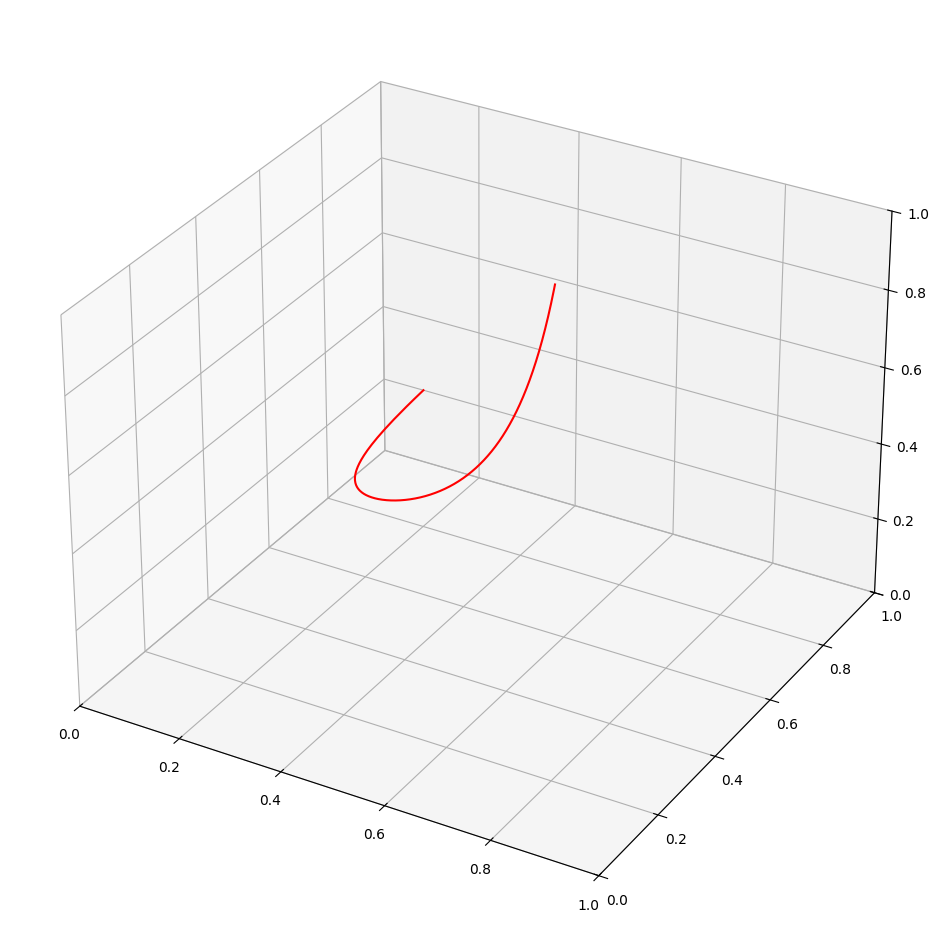

In [83]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
hook(ax)

# Experiments

In [84]:
# zero of payfield, x as function of z
x_crit(0.5)

0.5

In [85]:
# zero of payfield, y as function of z
y_crit(0.5)

0.5

In [86]:
SFTRL_GAMES[0].choice(1, 3, 1, 2, 8, 4)

[0.11920292202211755,
 0.8807970779778824,
 0.2689414213699951,
 0.7310585786300049,
 0.9820137900379085,
 0.01798620996209156]

In [87]:
SFTRL_GAMES[0].map_choice.ex

Matrix([
[exp(y0_0)/(exp(y0_0) + exp(y0_1))],
[exp(y0_1)/(exp(y0_0) + exp(y0_1))],
[exp(y1_0)/(exp(y1_0) + exp(y1_1))],
[exp(y1_1)/(exp(y1_0) + exp(y1_1))],
[exp(y2_0)/(exp(y2_0) + exp(y2_1))],
[exp(y2_1)/(exp(y2_0) + exp(y2_1))]])

In [88]:
def small():
    return 0.02#np.random.uniform(0, 1e-1)
small()

multiplier = 3

In [89]:
A = [0,1]
pay_dict = { (a, b, c) : (GH.payoff_tensors[0][a,b,c], GH.payoff_tensors[1][a,b,c], GH.payoff_tensors[2][a,b,c]) for a in A for b in A for c in A  }

In [90]:
pay_dict

{(0, 0, 0): (7, -15, -8),
 (0, 0, 1): (-29, 23, -8),
 (0, 1, 0): (1, -10, 1),
 (0, 1, 1): (24, 0, 0),
 (1, 0, 0): (2, -3, 4),
 (1, 0, 1): (-6, -9, -6),
 (1, 1, 0): (7, 2, -6),
 (1, 1, 1): (0, 4, 5)}

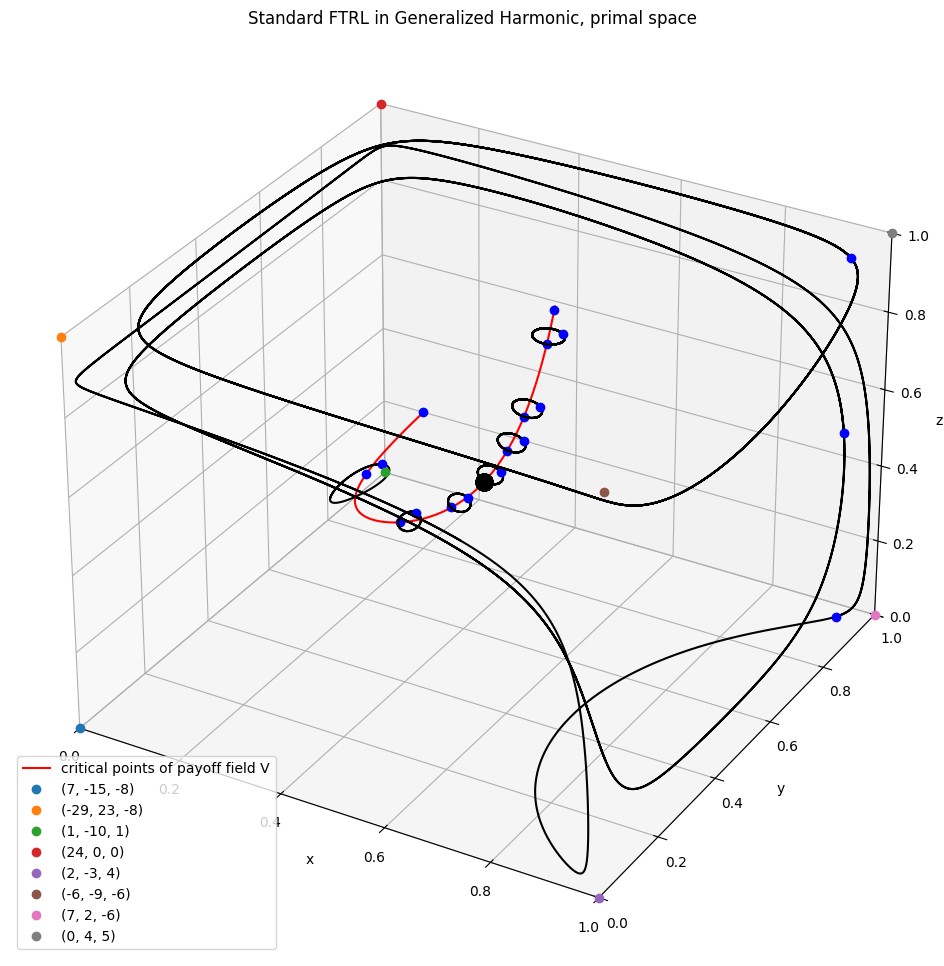

In [91]:
middle_z_values = [0.21, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]
extreme_z_values = [0.2, 0.99]
z_values = middle_z_values + extreme_z_values

# make initial points around zeros of payfield
initial_dual_points = [ make_initial_dual_point(x_crit(z), y_crit(z), z) for z in z_values  ] + [ make_initial_dual_point(x_crit(z) + small(), y_crit(z) + small(), z + small()) for z in middle_z_values  ] # + [ make_initial_dual_point(x_crit(z) + multiplier * small(), y_crit(z) + multiplier * small(), z + multiplier * small()) for z in middle_z_values  ]

# more far away
initial_dual_points += [ make_initial_dual_point( 0.95, 0.95, 0.5  ), make_initial_dual_point( 0.95, 0.95, 0.01  ),  make_initial_dual_point( 0.95, 0.95, 0.95  ) ] 

fig = plt.figure(figsize=(12, 12))


for i, s in enumerate(SFTRL_GAMES):
    ax = fig.add_subplot(len(SFTRL_GAMES), 1, i+1, projection='3d')
    hook(ax)
    
    for y0 in initial_dual_points:

        dual_points = odeint(s.sftrl_dyn, y0, time, args = (-0.0,))
        primal_points = [s.choice(*y) for y in dual_points]
        x00, x01, x10, x11, x20, x21 = coords_points(primal_points) # primal coords
        ax.plot(x01, x11, x21, 'k')
        ax.plot(0.5, 0.5, 0.5, 'ko', ms = 12)
        ax.plot(x01[0], x11[0], x21[0], 'bo')#, label = 'initial')
        #ax.plot(x01[1000], x11[1000], x21[1000], 'ro', label = 'final')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    for k in pay_dict:
        ax.plot(*k, 'o', label = str(pay_dict[k]))
    plt.legend(loc = 'best')
    plt.title(f'Standard FTRL in {s.name}, primal space')
    
    #plt.show()

# General expetiments

In [120]:
import random
time = np.linspace(0, 5, 1000)
num_orbits = 50

initial_dual_points = [[random.uniform(-3, 3) for _ in range(6)] for n in range(num_orbits)]
#initial_dual_points = [ [2, 2.5, 2.1, 2.4] ]

In [121]:
#initial_dual_points

In [122]:
initial_quot_points = [nfg.Utils.flatten(nfg.Utils.quotient(nfg.Utils.pack( y, skeleton ))) for y in initial_dual_points]
#initial_quot_points

In [123]:
initial_eff_quot_points = [nfg.Utils.flatten( [ z[1:] for z in nfg.Utils.quotient(nfg.Utils.pack( y, skeleton )) ] ) for y in initial_dual_points]
#initial_eff_quot_points

## finite games $\to$ constrained setting & entropic regularizer

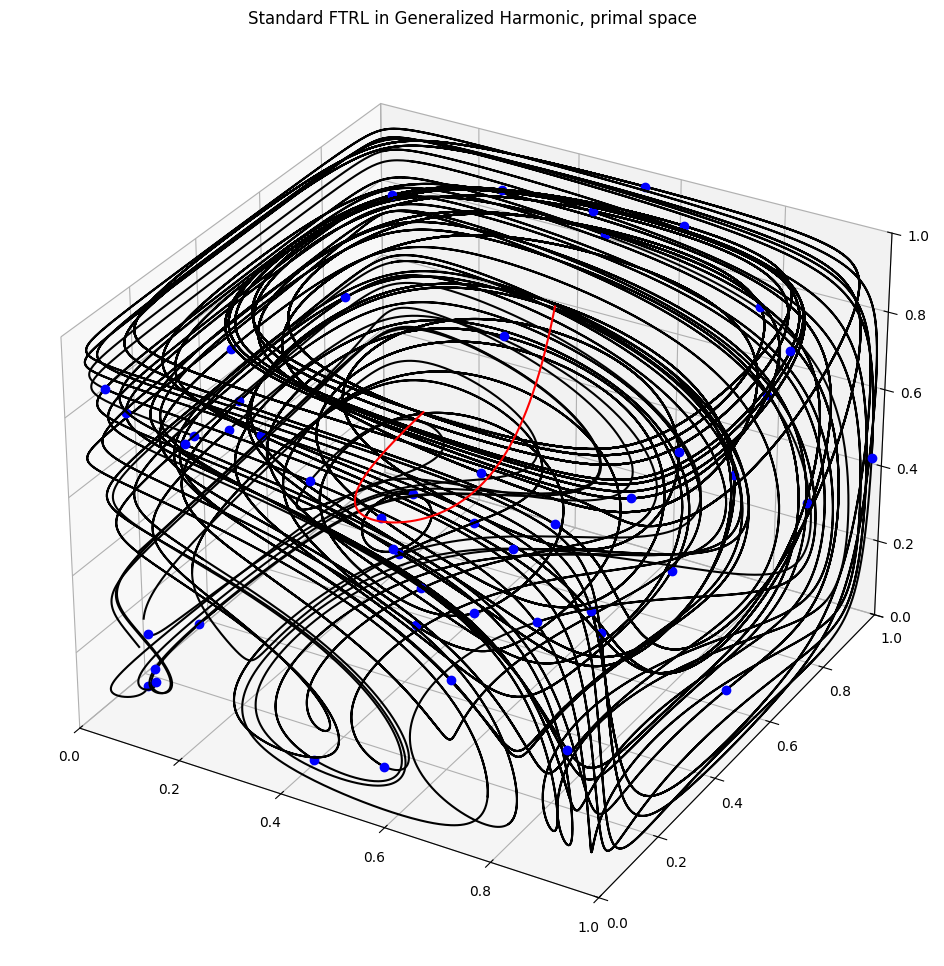

In [124]:
fig = plt.figure(figsize=(12, 12))


for i, s in enumerate(SFTRL_GAMES):
    ax = fig.add_subplot(len(SFTRL_GAMES), 1, i+1, projection='3d')
    
    for y0 in initial_dual_points:

        dual_points = odeint(s.sftrl_dyn, y0, time, args = (-0.0,))
        primal_points = [s.choice(*y) for y in dual_points]
        x00, x01, x10, x11, x20, x21 = coords_points(primal_points) # primal coords
        ax.plot(x01, x11, x21, 'k')
        ax.plot(x01[0], x11[0], x21[0], 'bo', label = 'initial')
        #ax.plot(x01[1000], x11[1000], x21[1000], 'ro', label = 'final')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
    plt.title(f'Standard FTRL in {s.name}, primal space')
    hook(ax)
    #plt.show()

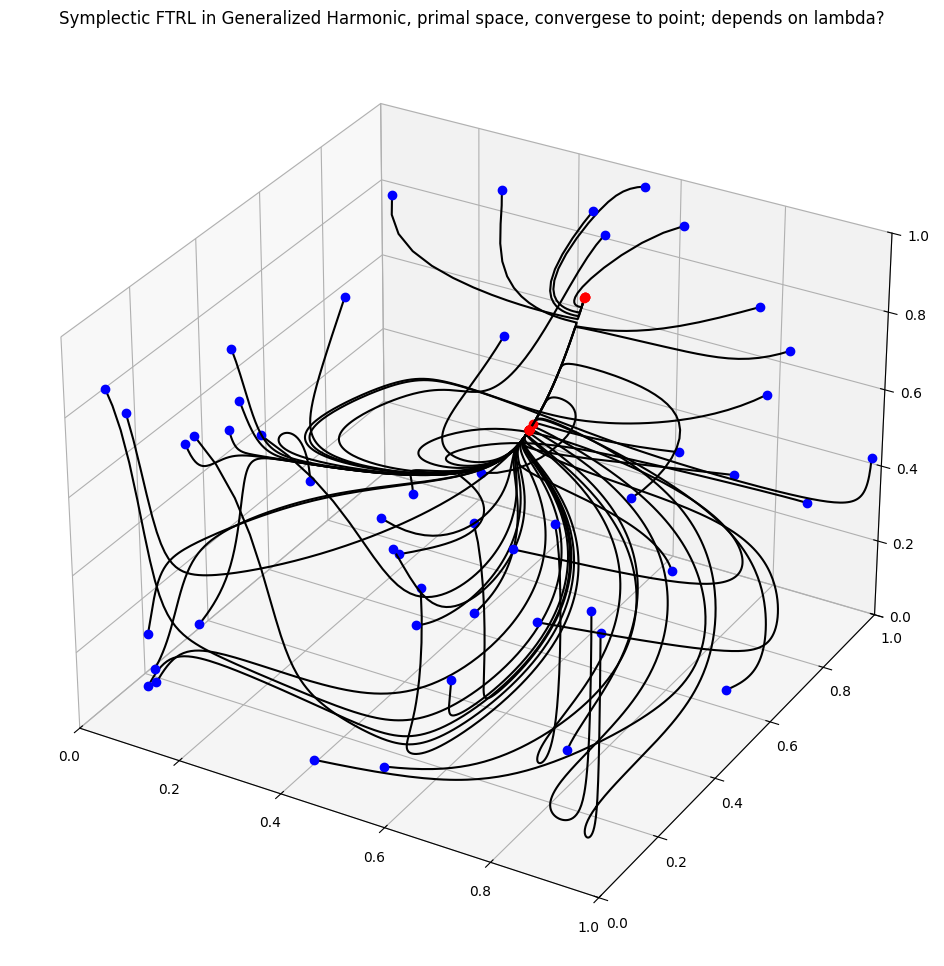

In [125]:
# dual; symplectic

fig = plt.figure(figsize=(12, 12))


for i, s in enumerate(SFTRL_GAMES):
    ax = fig.add_subplot(len(SFTRL_GAMES), 1, i+1, projection='3d')
    
    for y0 in initial_dual_points:

        dual_points = odeint(s.sftrl_dyn, y0, time, args = (-0.2,))
        primal_points = [s.choice(*y) for y in dual_points]
        x00, x01, x10, x11, x20, x21 = coords_points(primal_points) # primal coords
        ax.plot(x01, x11, x21, 'k')
        ax.plot(x01[0], x11[0], x21[0], 'bo', label = 'initial')
        ax.plot(x01[-1], x11[-1], x21[-1], 'ro', label = 'final')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
    plt.title(f'Symplectic FTRL in {s.name}, primal space, convergese to point; depends on lambda?')
    #plt.show()

# This is good! symplectic correction and pulling form, euclidean metric, without trouble of quotient and sharping!

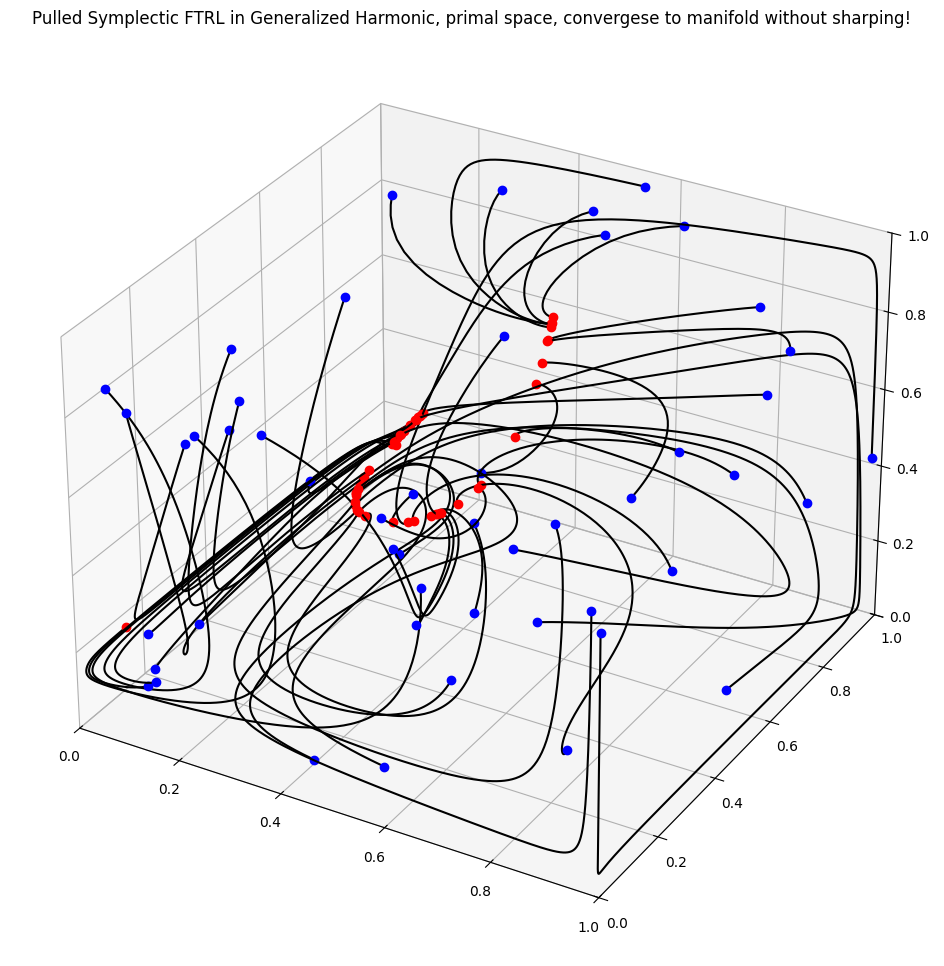

In [140]:
# dual; symplectic pulled version

fig = plt.figure(figsize=(12, 12))


for i, s in enumerate(SFTRL_GAMES):
    ax = fig.add_subplot(len(SFTRL_GAMES), 1, i+1, projection='3d')
    
    for y0 in initial_dual_points:

        dual_points = odeint(s.sftrl_dyn_2, y0, time, args = (-0.2,))
        primal_points = [s.choice(*y) for y in dual_points]
        x00, x01, x10, x11, x20, x21 = coords_points(primal_points) # primal coords
        ax.plot(x01, x11, x21, 'k')
        ax.plot(x01[0], x11[0], x21[0], 'bo', label = 'initial')
        ax.plot(x01[-1], x11[-1], x21[-1], 'ro', label = 'final')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
    plt.title(f'Pulled Symplectic FTRL in {s.name}, primal space, convergese to manifold without sharping!')
    #plt.show()

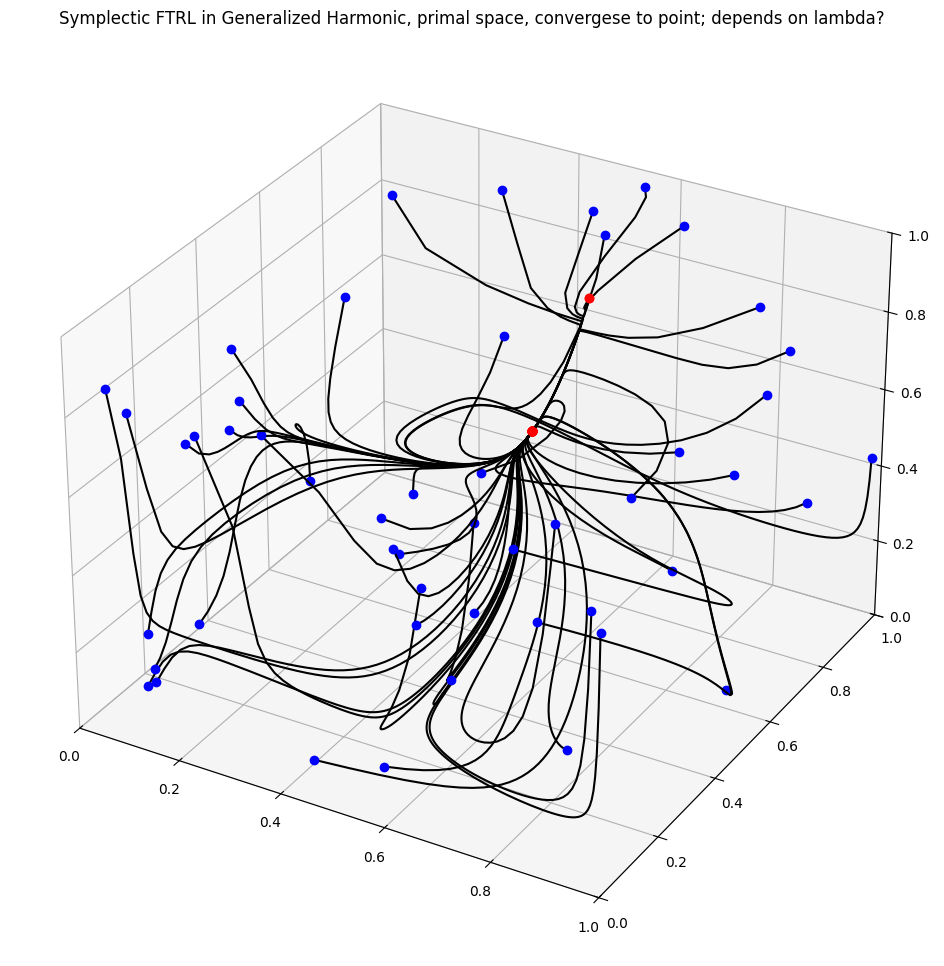

In [126]:
fig = plt.figure(figsize=(12, 12))


for i, s in enumerate(SFTRL_GAMES):
    ax = fig.add_subplot(len(SFTRL_GAMES), 1, i+1, projection='3d')
    
    for y0 in initial_dual_points:

        dual_points = odeint(s.sftrl_dyn, y0, time, args = (-0.6,))
        primal_points = [s.choice(*y) for y in dual_points]
        x00, x01, x10, x11, x20, x21 = coords_points(primal_points) # primal coords
        ax.plot(x01, x11, x21, 'k')
        ax.plot(x01[0], x11[0], x21[0], 'bo', label = 'initial')
        ax.plot(x01[-1], x11[-1], x21[-1], 'ro', label = 'final')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
    plt.title(f'Symplectic FTRL in {s.name}, primal space, convergese to point; depends on lambda?')
    #plt.show()

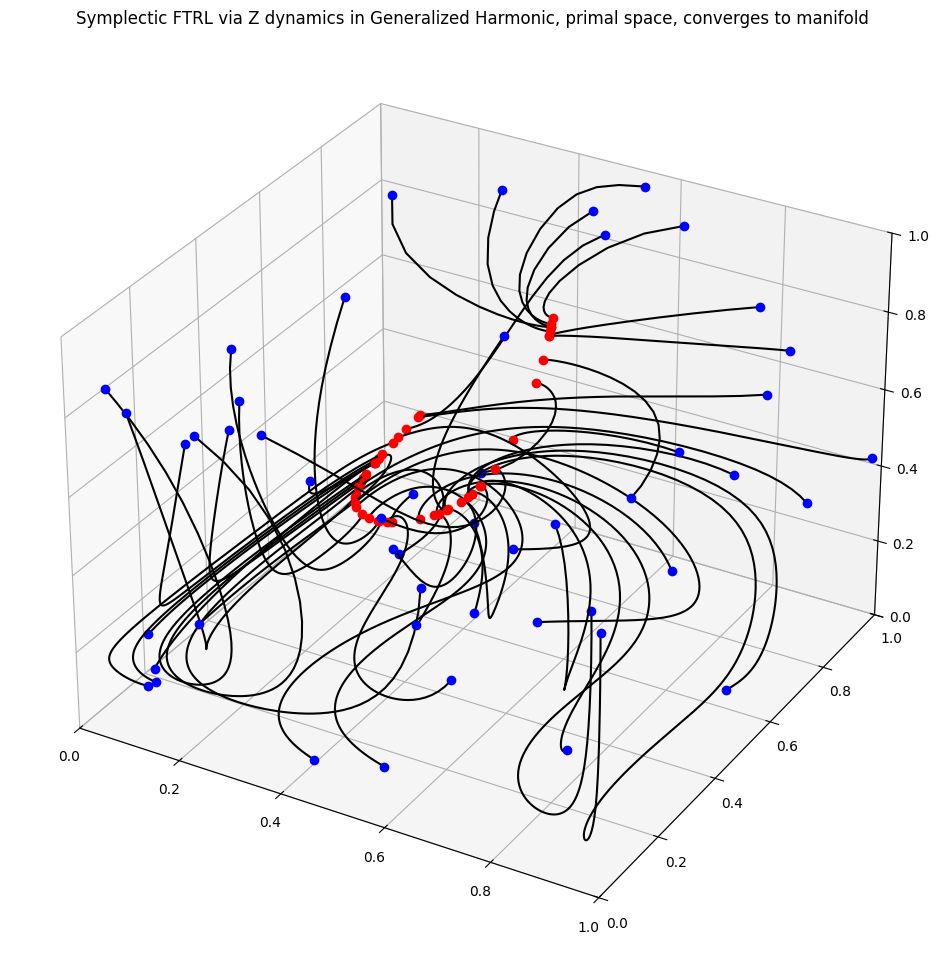

In [127]:
fig = plt.figure(figsize=(12, 12))
time = np.linspace(0, 100, 10000)

for i, s in enumerate(ZSFTRL_GAMES):
    ax = fig.add_subplot(len(ZSFTRL_GAMES), 1, i+1, projection='3d')
    
    for z0 in initial_quot_points:

        quot_points = odeint(s.sftrl_dyn, z0, time, args = (-0.2,))
        primal_points = [s.choice(*z) for z in quot_points]
        x00, x01, x10, x11, x20, x21 = coords_points(primal_points) # primal coords
        ax.plot(x01, x11, x21, 'k')
        ax.plot(x01[0], x11[0], x21[0], 'bo', label = 'initial')
        ax.plot(x01[-1], x11[-1], x21[-1], 'ro', label = 'final')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
    plt.title(f'Symplectic FTRL via Z dynamics in {s.name}, primal space, converges to manifold')
    #plt.show()

In [128]:
initial_eff_quot_points[:10]

[[0.8457155914218011, -1.7791984297313133, 1.6194963505185576],
 [1.085642443117654, -3.254602602150875, 1.4120473999287038],
 [-3.3643090932078485, -0.26986781691289363, 0.0069690390102365996],
 [1.0427763110102752, 0.985940050019479, -1.3608582980201107],
 [-1.1048569736273153, -5.309833732649436, 1.6988813170676185],
 [0.16745894876111178, 3.7823186105377102, 3.706657228542434],
 [0.18493935725521826, -2.3206885999051394, -2.6168247664066104],
 [1.2534422648523122, 5.8763163145657735, 0.028175646926792197],
 [-2.733351864689785, -0.2976312279021798, 0.3725467362111399],
 [-0.1781367930487292, 5.18739440520276, 1.4692912522668982]]

In [129]:
eff_ZSFTRL_GAMES

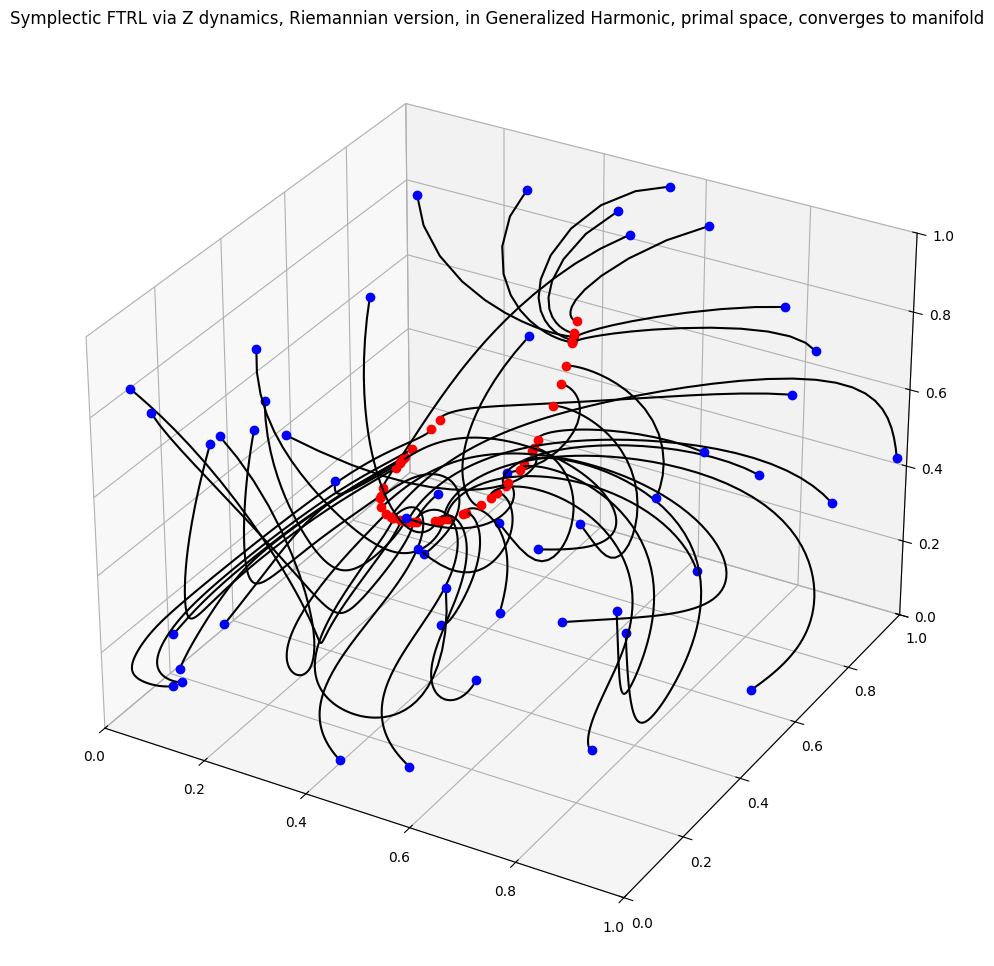

In [130]:
fig = plt.figure(figsize=(12, 12))
time = np.linspace(0, 100, 10000)

for i, s in enumerate(eff_ZSFTRL_GAMES):
    ax = fig.add_subplot(len(eff_ZSFTRL_GAMES), 1, i+1, projection='3d')
    
    for z0 in initial_eff_quot_points:

        quot_points = odeint(s.geom_sftrl_dyn, z0, time, args = (-0.2,))
        primal_points = [s.choice(*z) for z in quot_points]
        x01, x11, x21 = coords_points(primal_points) # primal coords
        ax.plot(x01, x11, x21, 'k')
        ax.plot(x01[0], x11[0], x21[0], 'bo', label = 'initial')
        ax.plot(x01[-1], x11[-1], x21[-1], 'ro', label = 'final')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
    plt.title(f'Symplectic FTRL via Z dynamics, Riemannian version, in {s.name}, primal space, converges to manifold')
    #plt.show()

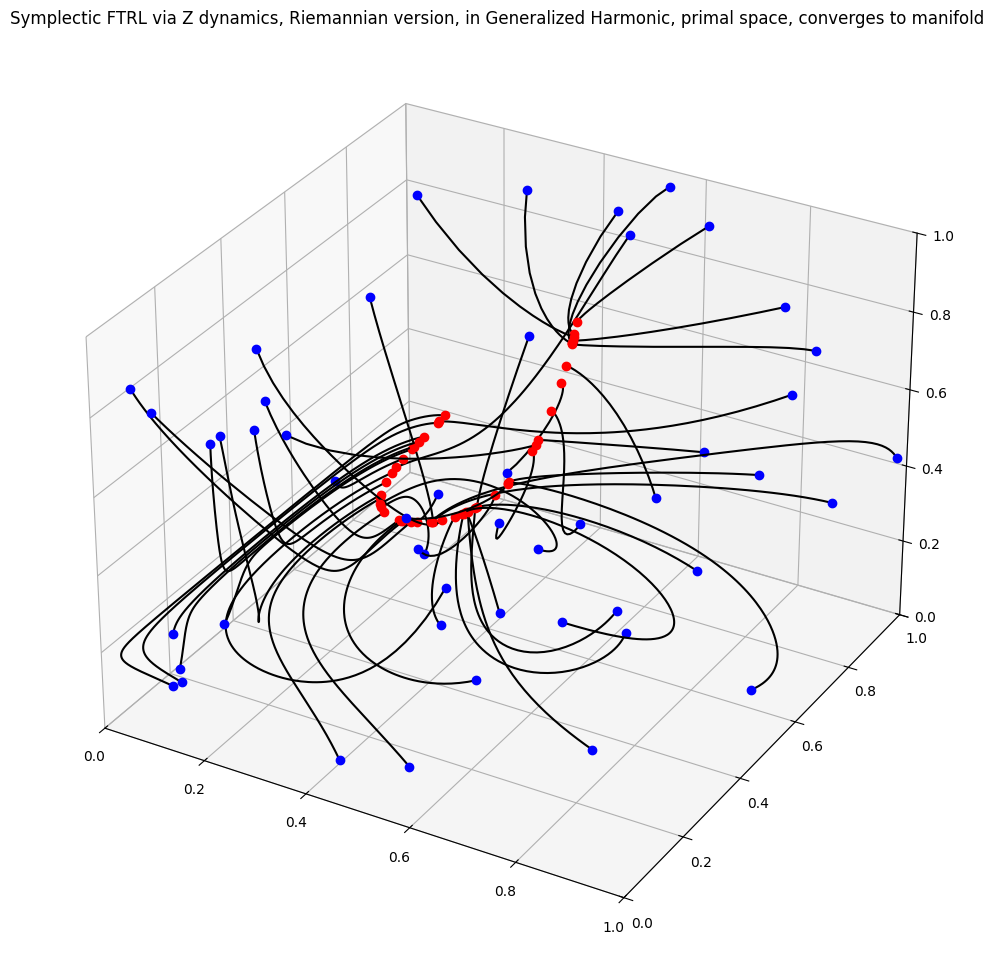

In [132]:
# faster convergence with pulled version
fig = plt.figure(figsize=(12, 12))
time = np.linspace(0, 100, 10000)

for i, s in enumerate(eff_ZSFTRL_GAMES):
    ax = fig.add_subplot(len(eff_ZSFTRL_GAMES), 1, i+1, projection='3d')
    
    for z0 in initial_eff_quot_points:

        quot_points = odeint(s.geom_sftrl_dyn_2, z0, time, args = (-0.2,))
        primal_points = [s.choice(*z) for z in quot_points]
        x01, x11, x21 = coords_points(primal_points) # primal coords
        ax.plot(x01, x11, x21, 'k')
        ax.plot(x01[0], x11[0], x21[0], 'bo', label = 'initial')
        ax.plot(x01[-1], x11[-1], x21[-1], 'ro', label = 'final')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
    plt.title(f'Symplectic FTRL via Z dynamics, Riemannian version, in {s.name}, primal space, converges to manifold')
    #plt.show()

# Open points
- write well theory of Z reduction, descending fields to quotient, pulling back form, Riemannian symplectic adjustment in Z
- understand why symplectic correction seems to converge (locally) to point via Y, and to manifold via Z
- establish connection between critical points of V and convergence manifold
- measure difference between Euclidean symplectic and Riemannian symplectic
- get convergence rates!
- ~~cf `2_find_harmonic_measure_PLAYGROUND`, zeros of payfield contained in surface of normalized harmonic measures: understand relation between zeros of payoff field and normalized harmonic measures; looks like set of zeros of payoff field is contained in surface of harmonic measures~~

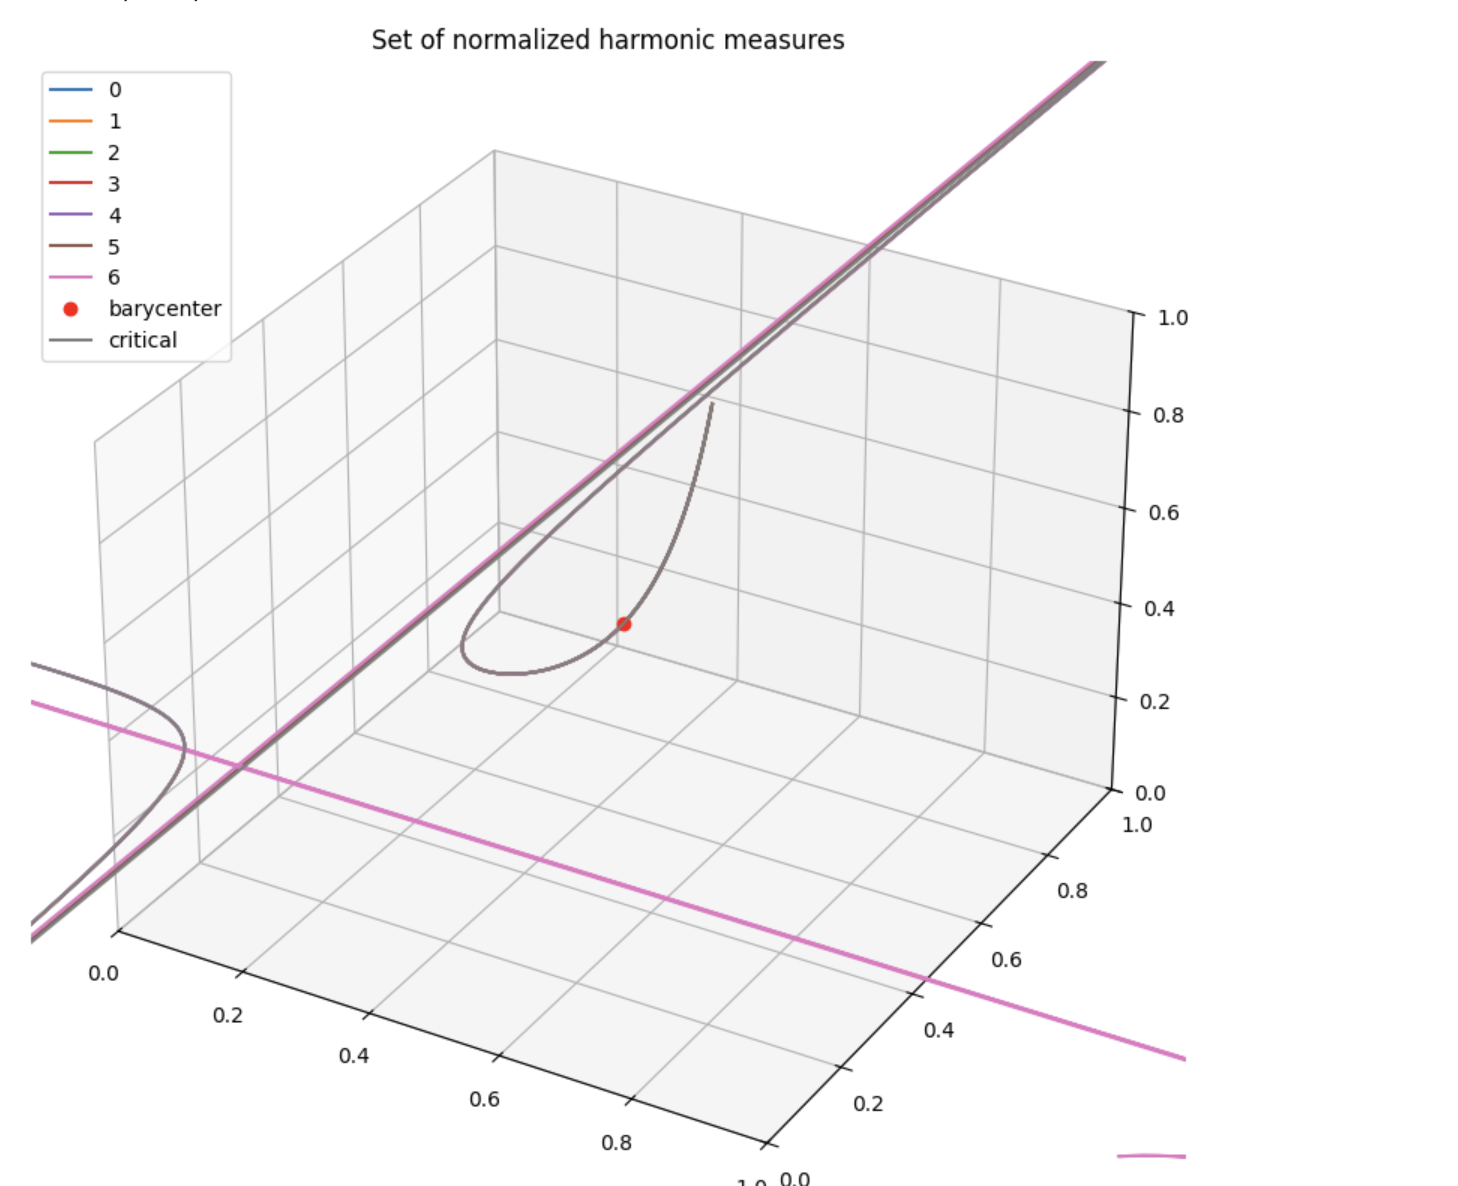
